# Grad-CAM | Ramprasaath R. Selvaraju
Paper: <https://arxiv.org/abs/1610.02391> Github: <https://github.com/ramprs/grad-cam/tree/master>\
Example code and gradcam module revised from Deepsurv: <https://github.com/deepsurv-cnn/main/blob/main/visualization/gradcam>

In [13]:
import os
import sys
import pandas as pd
import pickle
import shutil
from importlib import reload

from utils import *

sys.path.append('./gradcam_module')
import gradcam
import utils_gradcam
reload(gradcam)
reload(utils_gradcam)
from gradcam import GradCAM, GradCAMpp
from utils_gradcam import visualize_cam, normalize

In [14]:
def tensor_to_numpy(tensor):
    """Converts a PyTorch tensor to a NumPy array."""
    if tensor.dim() == 4:  # For tensors with shape [1, 1, H, W] or [1, 3, H, W]
        return tensor.squeeze().cpu().numpy()  # Remove the 1-dimensions and convert
    elif tensor.dim() == 3:  # For tensors with shape [3, H, W]
        return tensor.transpose(0, 2).transpose(0, 1).cpu().numpy()  # Reorder dimensions to [H, W, 3] and convert
    else:
        raise ValueError("Unsupported tensor shape: {}".format(tensor.shape))

def de_min_max_scaling(img_np, pretrained):
    if pretrained == 'TorchX':
        img_np = (img_np / 1024 + 1 ) / 2 * 0.5
        img_denormed = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    elif pretrained == 'ImageN': 
        img_denormed = img_np + 0.5

    return img_denormed

def clahe(X_bbox, cl, gs):
    clahe = cv2.createCLAHE(clipLimit=cl*gs*gs, tileGridSize=(gs, gs))
    X_histeq = []
    for i in range(len(X_bbox)):
        # img = X_bbox[i] + 0.5
        img = X_bbox[i,0,:,:] 
        img *= (255.0 / img.max())
        img = img.astype('uint8')
        img = clahe.apply(img)
        X_histeq.append(img)

    return X_histeq

def preprocess_seg_id(X, y, y_id, sharpen, histeq, cl, gs, pretrained):
    
    X_bbox = []
    img_size = 512
    for i in range(len(X)):
        ymin, ymax, xmin, xmax = bbox2_square(X[i,:,:,1])
        img = X[i,:,:,0].astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min())
        bbox = img[ymin:ymax+1, xmin:xmax+1]
        bbox = cv2.resize(bbox, dsize=(img_size, img_size), interpolation=cv2.INTER_LINEAR)
        X_bbox.append(bbox)
    
    X_bbox, y, y_id = shuffle(X_bbox, y, y_id)
    X_bbox = np.array(X_bbox)
    
    if histeq == 'True':
        X_histeq = clahe(X_bbox, cl, gs)
        X_bbox = np.array(X_histeq)
    else: 
        X_bbox = np.array(X_bbox)   

    if sharpen == 'True':
        X_sharp = sharpening(X_bbox)
        X_bbox = np.array(X_sharp)
    else:
        X_bbox = np.array(X_bbox)
    
    X_processed = []
    for i in range(len(X_bbox)):
        bbox = min_max_scaling(X_bbox[i], pretrained)
        X_processed.append(bbox)

    print('after processing',np.min(X_processed),np.max(X_processed))

    X_processed = np.expand_dims(X_processed, axis=-1)
    
    return X_processed, y, y_id

def display_heatmap_on_image(img, heatmap, idx, id_test, y_test, preds, histpath, pretrained):
    """Displays a grayscale image and the same image with a heatmap overlay."""

    gradcamDir = os.path.join(histpath, 'gradcam-test')
    if not os.path.exists(gradcamDir):
        os.makedirs(gradcamDir)

    img_np = tensor_to_numpy(img)  
    img_np =  de_min_max_scaling(img_np, pretrained)
    heatmap_np = tensor_to_numpy(heatmap)  

    # Convert grayscale image to RGB format for display
    img_rgb = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
    
    # Overlay the heatmap on the image
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb, cmap='gray')
    plt.title(id_test[idx]+" actual: %s predicted: %s" % (y_test[idx], preds), fontsize=10)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(img_rgb, cmap='gray')
    plt.imshow(heatmap_np, alpha=0.5, cmap='jet')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(gradcamDir+'/{}.png'.format(id_test[idx]), format="PNG")
    plt.show()
    # plt.close('all')

Testing data distribution
x_test torch.Size([180, 1, 512, 512])
True:  54
False:  126


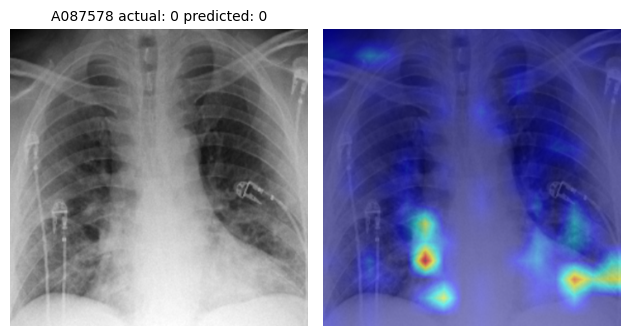

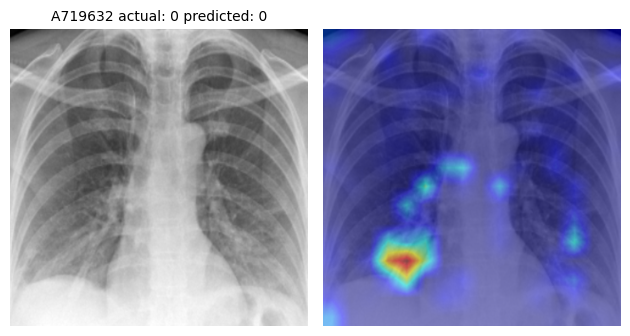

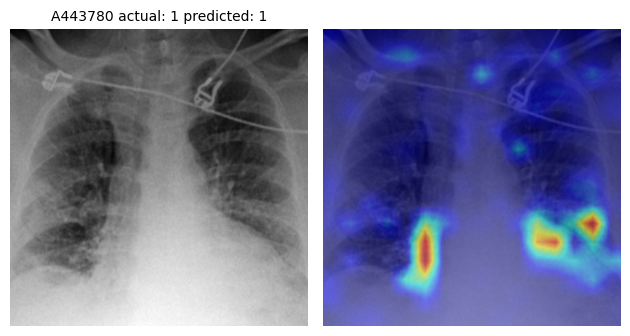

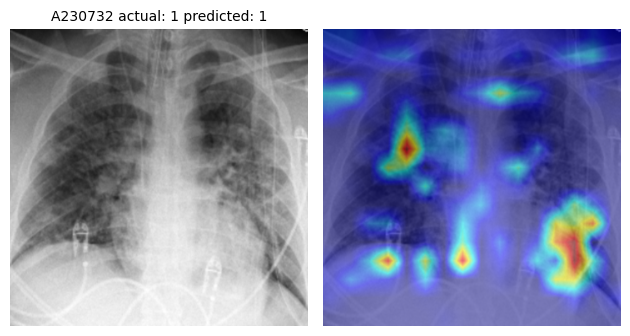

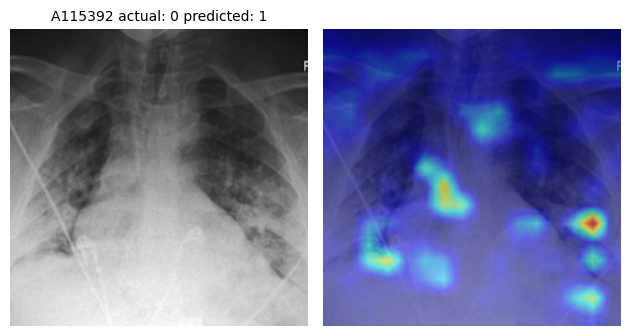

In [47]:
modelName = 'TorchX-SBU-RSNA_SGD_.00005_bs64'
pretrained = modelName.split('-')[0]

histf = './history/'
histpath = os.path.join(histf, modelName)

gradcamDir = os.path.join(histpath, 'gradcam-test')
if os.path.exists(gradcamDir):
    shutil.rmtree(gradcamDir)

# load testing data
test_data = np.load('/path/to/test_data.npy')
test_label = pd.read_csv('/path/to/test_label.csv')
x_test = np.array(test_data)
y_test = np.array(test_label['Label'].astype(int))
id_test = np.array(test_label['ID'])
# preprocessing according to pretrained model
x_test, y_test, id_test = preprocess_seg_id(x_test, y_test, id_test, 'False', 'False', 0, 0, pretrained)
x_test = np.transpose(x_test, (0, 3, 1, 2))
x_test = torch.from_numpy(x_test)
print('Testing data distribution')
print('x_test', x_test.shape)
print("True: ", y_test.sum())
print("False: ",len(y_test) - y_test.sum())

# load model
weightPath  =  histpath + '/checkpoint/model_fold_1_best.pt'
model = load_model_weight(weightPath, pretrained)
model.eval()

# generate gradcam
gradcam = GradCAM.from_config(model_type='resnet', arch=model.base_model, layer_name='layer4')
num_images = 5
for i in range(num_images):
    idx = random.randint(0, len(y_test) - 1)
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    img = x_test[idx]
    img = img.unsqueeze(0)
    img = img.float()  

    # get a GradCAM saliency map on the class index 10.
    mask, _ = gradcam(img, class_idx=0)
    # make heatmap from mask and synthesize saliency map using heatmap and img
    heatmap, cam_result = visualize_cam(mask, img)

    with torch.no_grad():  # No need to track gradients for inference
        pred = model(img)
    pred = torch.sigmoid(pred)
    preds = int(pred >= 0.5)

    display_heatmap_on_image(img, heatmap, idx, id_test, y_test, preds, histpath, pretrained)

